# Magic Code

In [7]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 21.9 MB/s eta 0:00:0000:0100:01


In [ ]:
# Install from command line
#sudo apt-get update
#sudo apt-get install libgl1-mesa-glx

In [1]:
import defdevice
defdevice.force_device('cuda:2') # Insert the cuda device that you're using.
import metrics
import nns
import immaskdataset
import importlib
import imcapdataset
import embdataset
import embedders
import losses
import imageops
import misc
import segmodel
import torch
import numpy as np
from tensorconversions import tnp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
%matplotlib inline

In [26]:
colorsl = [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [255, 0, 255], [0, 255, 255], [0, 0, 0], [255, 255, 255], [128, 128, 128], [128, 0, 0], [0, 128, 0], [0, 0, 128]]
colors = np.array(colorsl)
colorsl = [[c / 255 for c in color] for color in colorsl]

def array_to_rgb(array):
    n, y, x = array.shape
    max_indices = np.argmax(array, axis=0)
    rgb_image = np.zeros((y, x, 3), dtype=np.uint8)
    for i in range(n):
        mask = max_indices == i
        rgb_image[mask] = colors[i]
        
    return rgb_image

In [27]:
image_embr = embedders.M2FImageEmbedder()
text_embr = embedders.CLIPTextEmbedder()
model = nns.Linear(1, 1)
model.load("CSTableModel")
smodel = segmodel.CSModel(image_embr, text_embr, model)

def run_image_vid(img, labels):
    hmaps = smodel.forward(img, labels)

    return hmaps


In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def run_video(path, width, height, output_path = 'generated_video.mp4', fps = 30, frame_count = 1000, frame_average = 5, draw_period = 10):
    # Define the codec using VideoWriter_fourcc and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('generated_video.mp4', fourcc, fps, (width, height))


    class VideoReader:
        def __init__(self, video_path):
            self.cap = cv2.VideoCapture(video_path)

        def get_frame(self):
            ret, frame = self.cap.read()
            if not ret:
                return -1
            return frame

        def release(self):
            self.cap.release()

    video_path = './Vid.mp4'
    video_reader = VideoReader(video_path)

    hmaps = []
    for i in range(frame_count):
        frame = video_reader.get_frame() # Get next video frame
        if frame is -1:
            break
        frame = frame[:height, :width]
            
        #There's prolly a problem with RGB BGR.
        hmaps.append(run_image_vid(frame, labels))
        
        #Averaging over previous heatmaps
        if len(hmaps) > frame_average:
            hmaps = hmaps[1:]
        avg = np.array(hmaps).mean(axis = 0)
        res_frame = array_to_rgb(avg)
        
        out.write(res_frame // 2 + frame // 2) #Writing to video file
        
        #spam
        if i % draw_period == 0:
            print('On frame ', i, '/', frame_count)
            plt.figure()
            plt.imshow(res_frame)
            plt.title('frame ' + str(i))

    video_reader.release()

    out.release()


<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-28-cfeaafa6002b>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if frame is -1:


# Demo

On frame  0 / 50000
On frame  300 / 50000
On frame  600 / 50000
On frame  900 / 50000
On frame  1200 / 50000
On frame  1500 / 50000
On frame  1800 / 50000
On frame  2100 / 50000
On frame  2400 / 50000
On frame  2700 / 50000
On frame  3000 / 50000
On frame  3300 / 50000
On frame  3600 / 50000
On frame  3900 / 50000
On frame  4200 / 50000
On frame  4500 / 50000


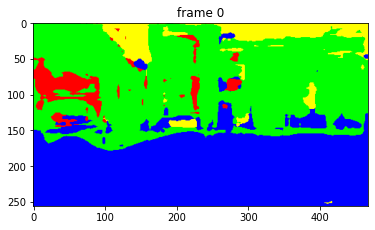

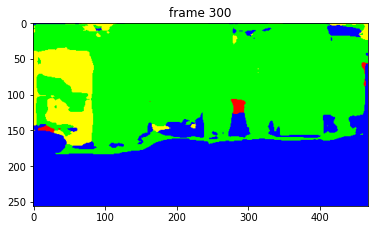

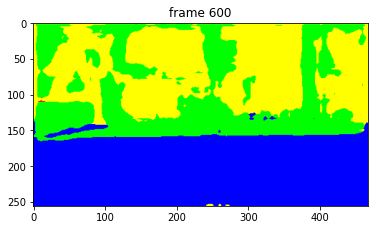

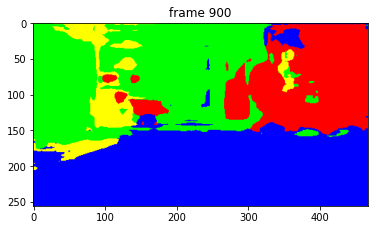

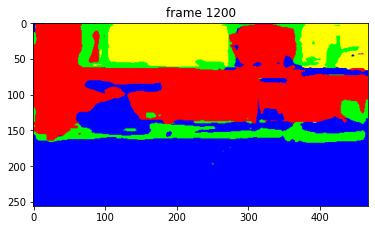

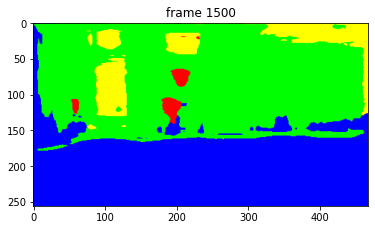

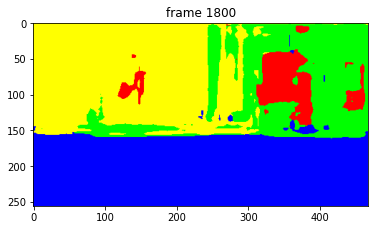

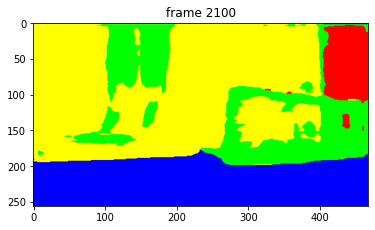

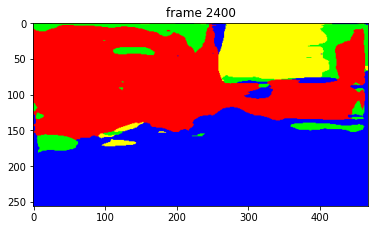

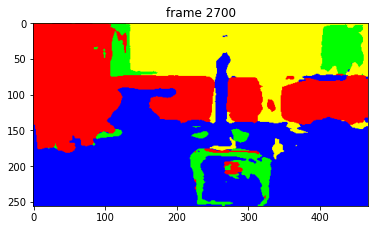

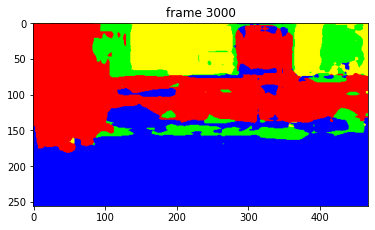

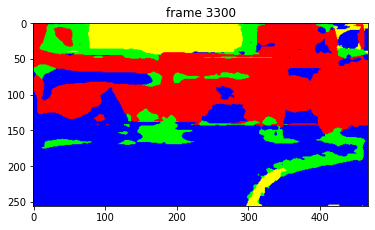

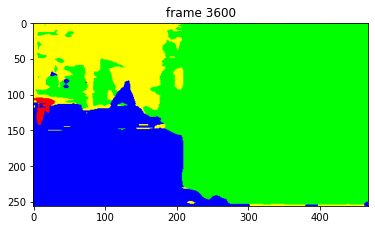

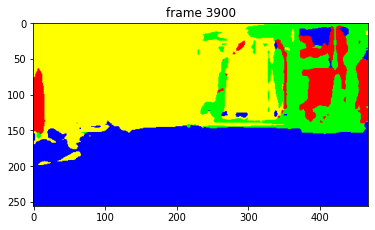

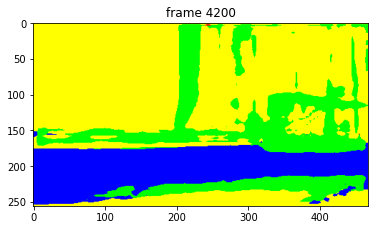

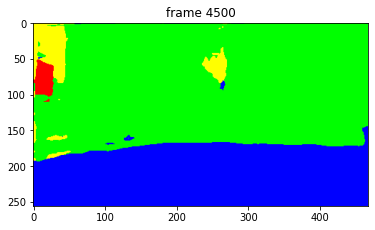

In [29]:
labels = [ 'Furniture', 'Wall / Barrier', 'floor', 'other']

path = './Vid.mp4'
width, height = (468, 256)
output_path = 'generated_video.mp4'
fps = 30
frame_count = 50000 #Maximum amount of frames to segment
frame_average = 5 #How many frames to average segmentation over.
draw_period = 300 #How frequently to output example segmentations.

run_video(path, width, height, output_path, fps, frame_count, frame_average, draw_period)